# Comparison various configuration

In [2]:
# Global approach
# Comparison between all machine learning algorithms over test period: 2011-2013


In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
import datetime
import netCDF4 as nc4

In [2]:
from src.feature_extraction import baseline
from src.modelling import sit_corrected
from src.visualization import visualize_pca
from src.visualization import visualize_sit_corr as vsc
from src.visualization import visu_intercomp_pc as vip
from src.utils import modif_plot
from src.utils import tardisml_utils
from src.utils import load_config

In [3]:
rootdir = tardisml_utils.get_rootdir()

In [ ]:
models = {}
pathes = []
names = []

## LSTM model
ml_name ='LSTM3_bk'
irootdir= f'{rootdir}'

# Build1
pathes += ['Leo/results/lstm_231212-183723/']
names += ['var2']

# Build2
pathes += ['Leo/results/lstm_231212-183743/']
names += ['var3']

# # Build3
# pathes += ['Leo/results/lstm_231212-183758/']
# names += ['var4']

# # Build4
# pathes += ['Leo/results/lstm_231212-183810/']
# names += ['var5']

# # Build5
# pathes += ['Leo/results/lstm_231212-183826/']
# names += ['var6']

# # Build6
# pathes += ['Leo/results/lstm_231212-183840/']
# names += ['var7']

In [44]:
# -----------------------------------------------------
#                   History
# -----------------------------------------------------
models_str = 'models_history'
models = {}
pathes = []
names = []
    
## LSTM model
ml_name ='LSTM3_bk'
irootdir= f'{rootdir}'
    
# Build1
pathes += ['Leo/results/lstm_231215-160924/']
names += ['H2']

# Build2
# pathes += ['Leo/results/lstm_231215-161010/']
pathes += ['Leo/results/lstm_231215-184609/']
names += ['H3']

# # Build3
pathes += ['Leo/results/lstm_231215-161416/']
names += ['H4']

# # Build4
pathes += ['Leo/results/lstm_231215-161445/']
names += ['H5']

# -----------------------------------------------------
# -----------------------------------------------------

In [45]:
for ipath, name in zip(pathes, names):
    ifile = f'{irootdir}{ipath}'
    print('ifile:  ', ifile)
    models[f'{name}'] = sit_corrected.SITCorrected(ifile, name=ml_name, verbose=1)

ifile:   /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-160924/
Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-160924/config_h2.yaml
Folder: Leo/results/lstm_231215-160924/figures/sit_reconstruct/

Initialisation SIT from LSTM3_bk
ML prediction .nc file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-160924/ml/ypred_LSTM3_bk_2011_2022.nc
ifile:   /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-184609/
Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-184609/config_h3.yaml
Folder: Leo/results/lstm_231215-184609/figures/sit_reconstruct/

Initialisation SIT from LSTM3_bk
ML prediction .nc file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-184609/ml/ypred_LSTM3_bk_2011_2022.nc
ifile:   /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-161416/
Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_231215-161416/config_h4.yaml
Folder: Leo/re

In [46]:
# Parameters    
n_mdl = len(list(models.keys()))
n_pc = models[names[0]].ytrue.shape[1]  # get number of component from first model
    
# Time axis for test period (always 2011-2014)
chrono = models[names[0]].chronoe['date'][:1096].to_xarray()

In [47]:
# ------------------------------------------------
##            Bias for violin plots
# ------------------------------------------------

bias_pc = np.zeros((1096, n_pc*n_mdl))

ii = 0  
for i_pc in range(n_pc):
    for nm in range(n_mdl):
        m_needpast, m_needfutur = models[names[nm]].config.needpast, models[names[nm]].config.needfutur
        length_ts = models[names[nm]].config.ntest-m_needfutur
        bias_pc[m_needpast:length_ts, ii] = (models[names[nm]].ypred.isel(time=slice(m_needpast, length_ts)) -
                          models[names[nm]].ytrue.isel(time=slice(m_needpast, length_ts)))[:,i_pc]
        ii += 1

In [13]:
# ------------------------------------------------
##                 Bias
# ------------------------------------------------

biases = []
biases_pc = np.zeros((n_pc, n_mdl))

for name in names:
    biases += [models[name].ypred.isel(time=slice(None, models[name].config.ntest))
             - models[name].ytrue.isel(time=slice(None, models[name].config.ntest))]

for n in range(n_mdl):
    biases_pc[:, n] = biases[n].mean('time')
    
# ------------------------------------------------
##                    RMSE
# ------------------------------------------------

rmse = []
rmse_pc = np.zeros((n_pc, n_mdl))  # reshape to have (PC1 all models), (PC2 all models), PC3...

for name in names:
    rmse += [np.array(np.sqrt(models[name].ypred.isel(time=slice(None, models[name].config.ntest)) - 
                              models[name].ytrue.isel(time=slice(None, models[name].config.ntest))).mean(dim='time'))]

for n in range(n_mdl):
    rmse_pc[:, n] = rmse[n]

# ------------------------------------------------
##                 Correlation
# ------------------------------------------------

correlations = []
corr_pc = np.zeros((n_pc, n_mdl))

for name in names:
    correlations += [xr.corr(models[name].ypred.isel(time=slice(None, models[name].config.ntest)),
                             models[name].ytrue.isel(time=slice(None, models[name].config.ntest)), dim=('time'))] 

for n in range(n_mdl):
    corr_pc[:, n] = correlations[n]

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/xarray/core/computation.py:769: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/xarray/core/computation.py:769: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [19]:
# ------------------------------------------------
##                 Plots
# ------------------------------------------------
    
odir = '/scratch/project_465000269/edelleo1/Leo/results/intercomp_pc/'

In [8]:
from importlib import reload

In [11]:
reload(vip)

<module 'src.visualization.visu_intercomp_pc' from '/users/edelleo1/tardis/tardis-ml/src/visualization/visu_intercomp_pc.py'>

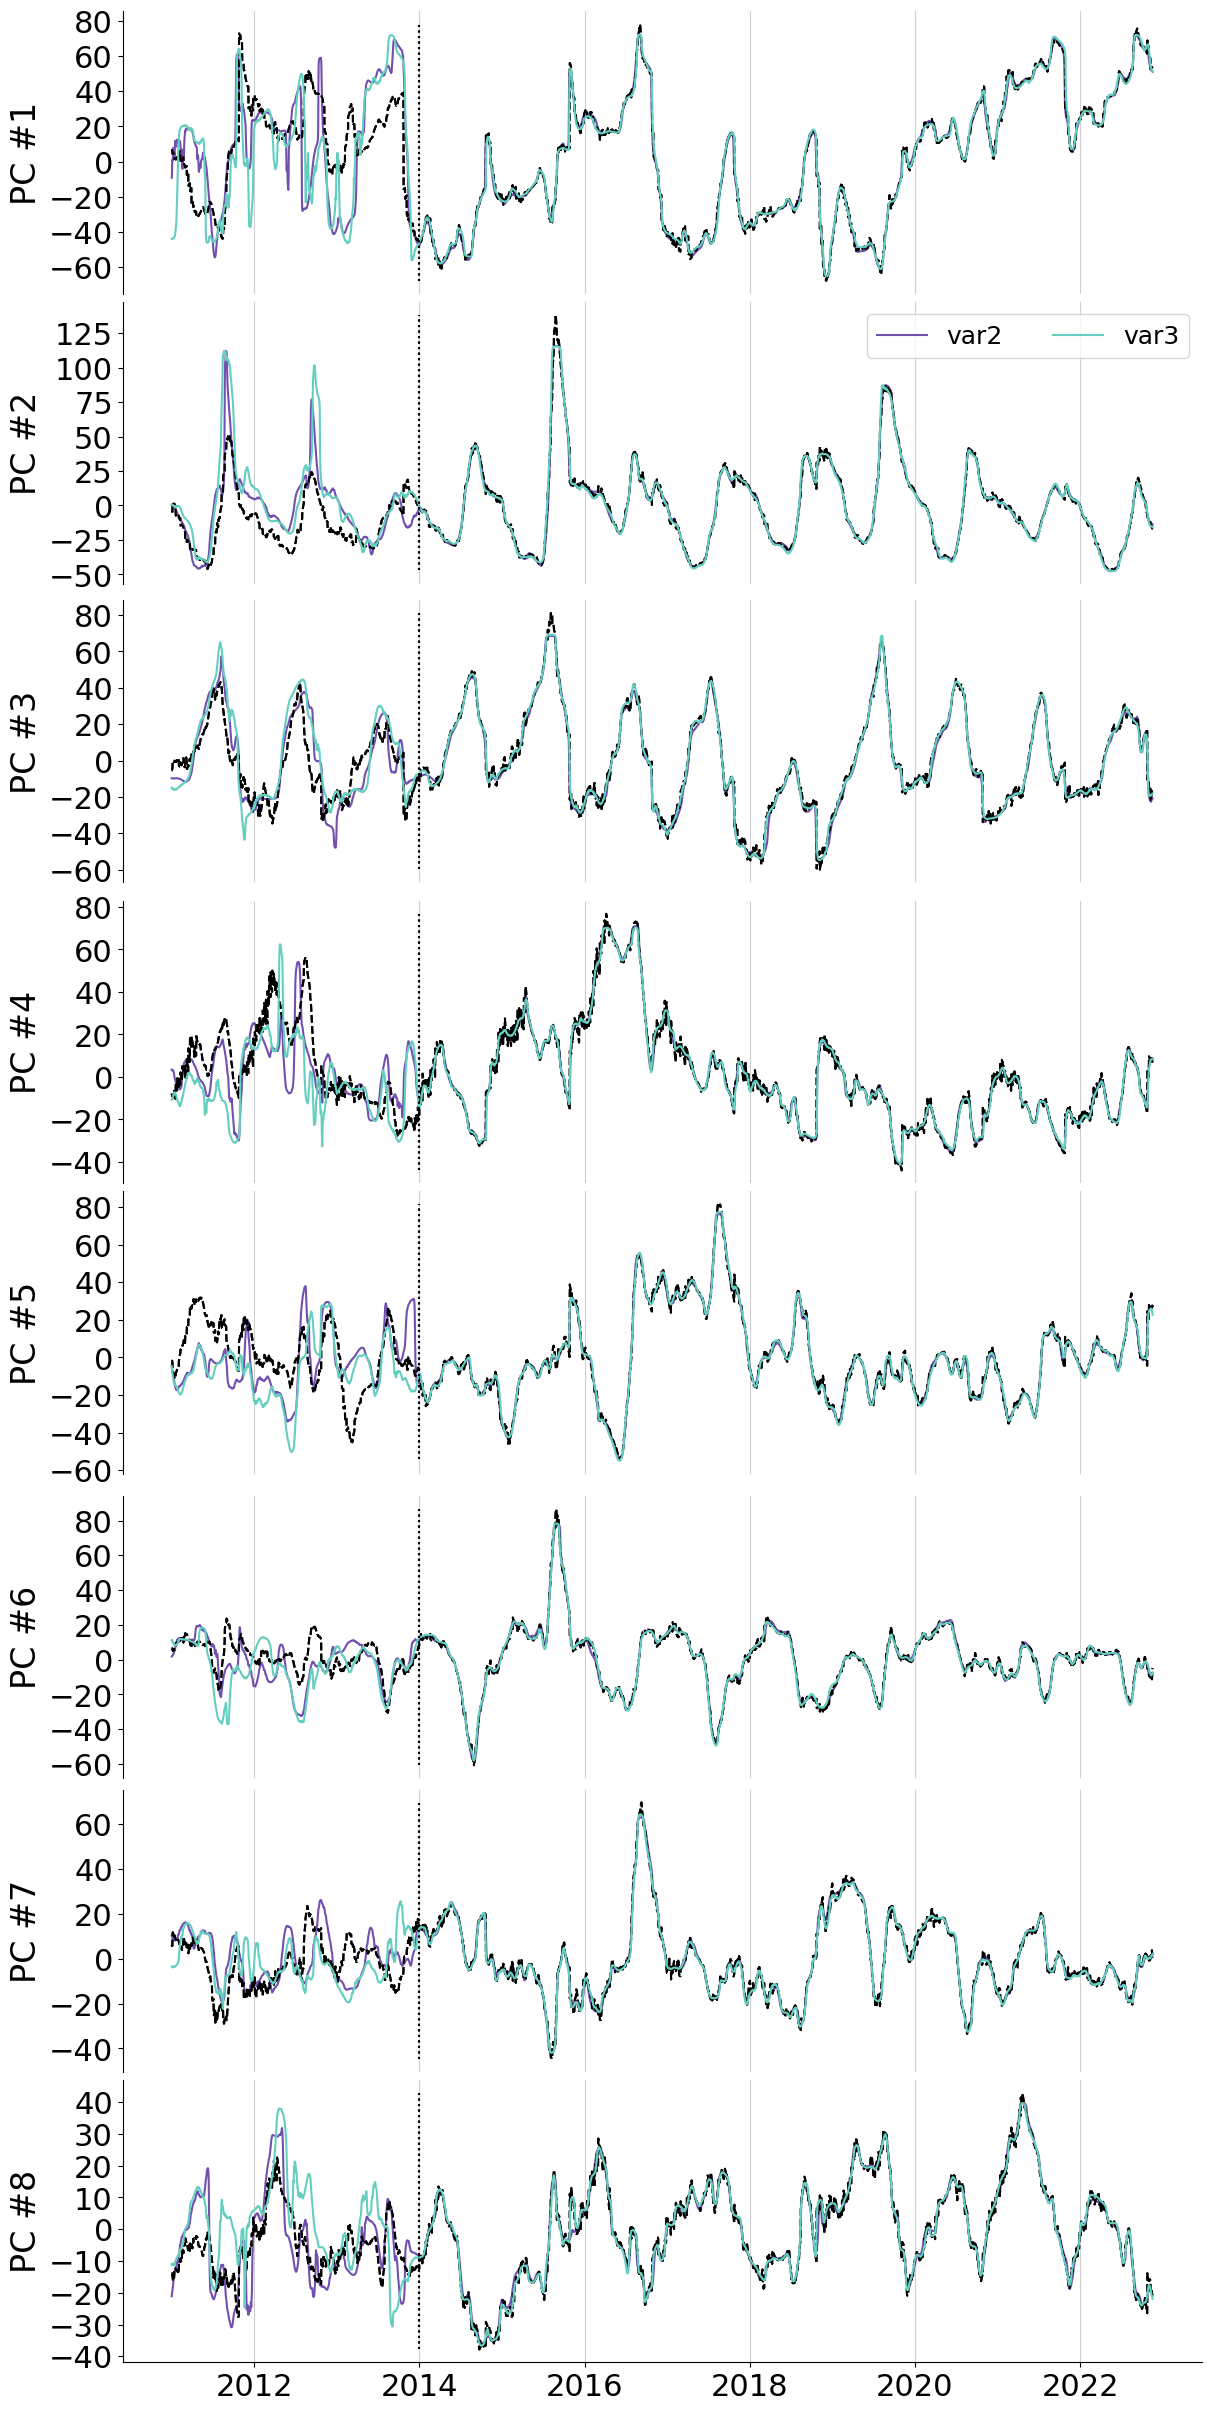

In [12]:
vip.draw_ypred_mulitple(models, n_pc, n_mdl, savefig=False)

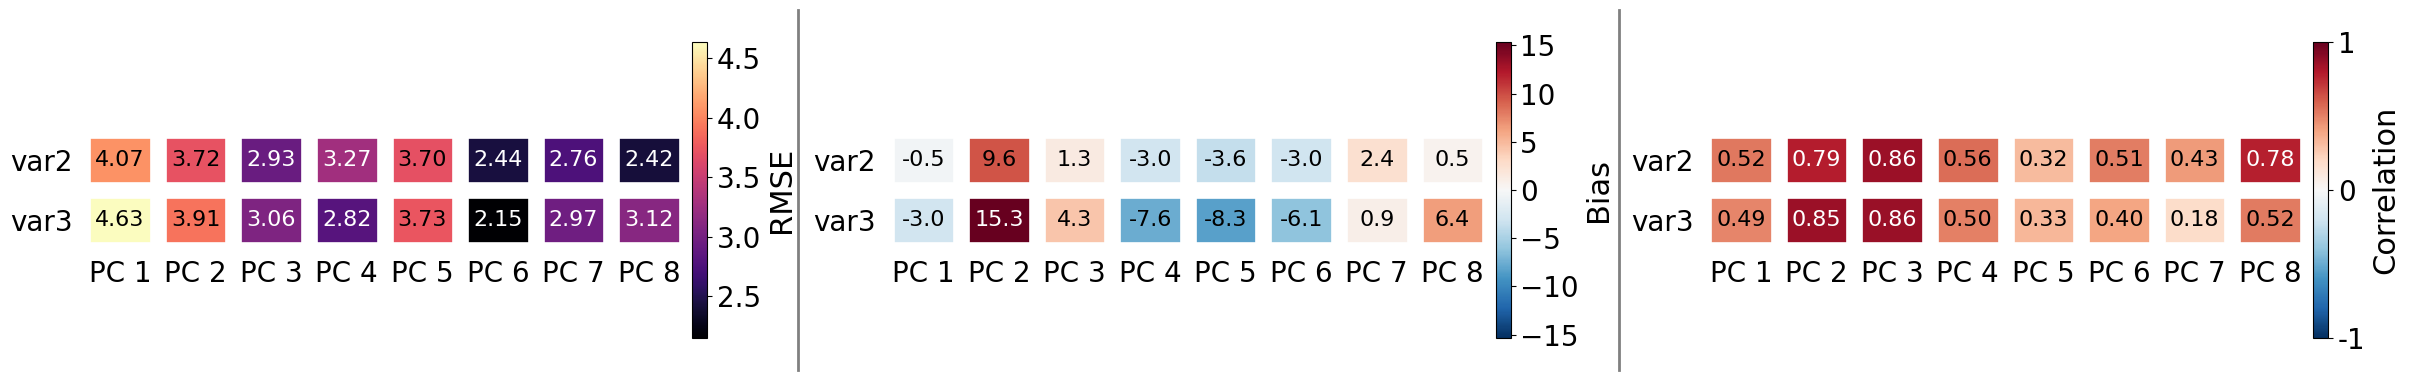

In [15]:
vip.draw_errors_intercomp(rmse_pc, biases_pc, corr_pc, names=names, 
                              models_str='', odir=odir, savefig=False)

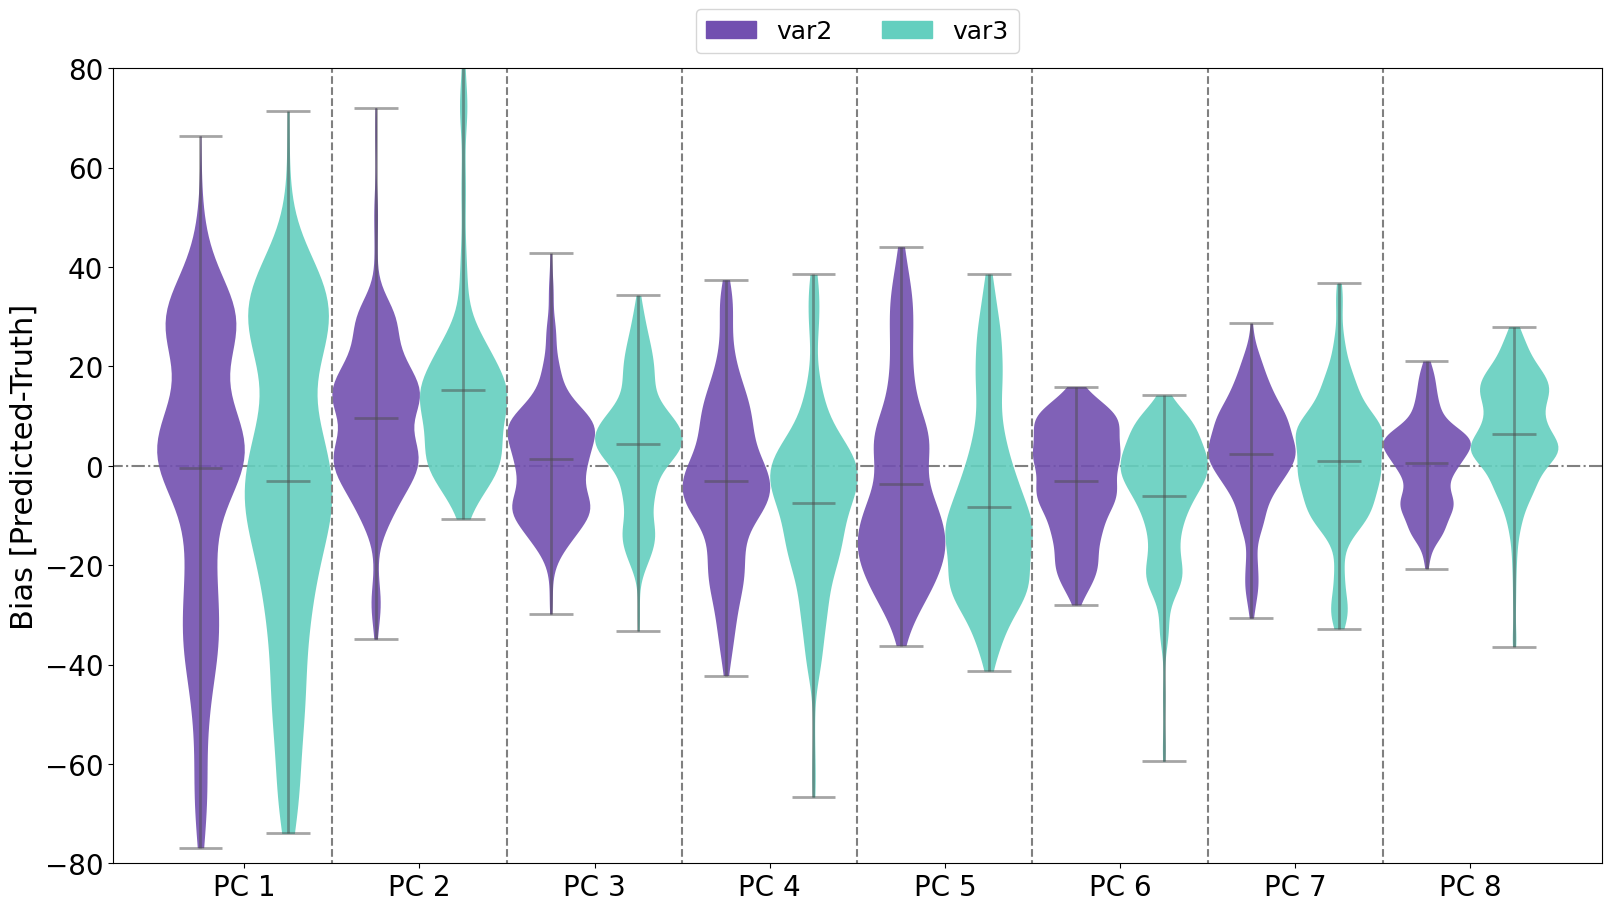

In [17]:
vip.draw_bias_violin(bias_pc, names=names, n_pc=n_pc, n_mdl=n_mdl, 
                         models_str='', odir=odir, savefig=False)
              

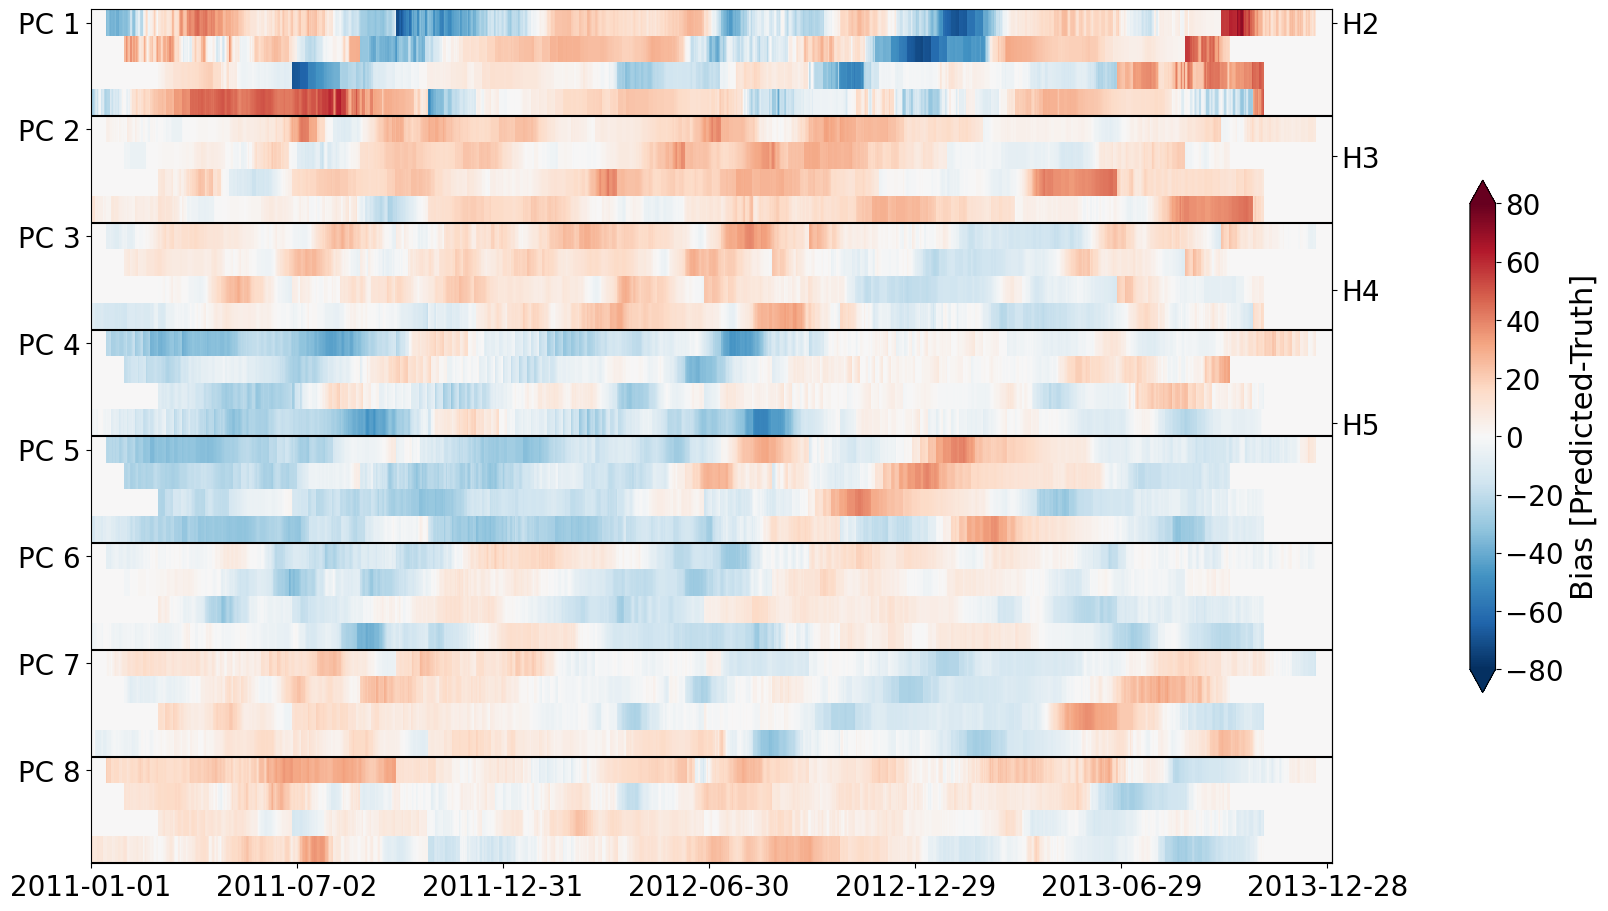

In [48]:
vip.draw_bias_time(bias_pc, chrono, names=names, n_pc=n_pc, n_mdl=n_mdl, 
                       models_str='', odir=odir, savefig=False)
    
    

# ------------------- DRAFT ------------------------

In [42]:
def draw_ypred_mulitple(models,
                        n_pc:int, n_mdl:int, max_plot=8,
                        models_str='models',
                        odir='', savefig=False, showfig=True):
    '''model, data classe ModelML or SModelDL
    '''

    # Parameters:
    ntest = models[list(models.keys())[0]].config.ntest
    colors = ['#7250B0', '#64CFBF', '#8ab17d', '#e9c46a', '#e76f51', '#ae2d68']
    
    if max_plot > n_pc: max_plot = n_pc
    
    fig, ax = plt.subplots(ncols=1, nrows=max_plot, figsize=(12,max_plot*3), constrained_layout=True)

    for i in range(max_plot):
        for nm, name in enumerate(models):
            model = models[name]
            ax[i].plot(model.chrono, model.ytrue[:,i], ls='--', c='k')  # label='TOPAZ', 
            ax[i].plot(model.chrono, model.ypred[:,i], label=f'{name}', c=colors[nm])

            mini, maxi = model.ytrue[:,i].min(), model.ytrue[:,i].max()
            ax[i].plot([model.chrono.iloc[ntest]]*2, [mini, maxi],ls=':', c='k')
            ax[i].set_ylabel(f'PC #{i+1}')

            ax[i].xaxis.grid(alpha=0.6)

        if i < max_plot-1:
            ax[i].spines[['right', 'top', 'bottom']].set_visible(False)
            ax[i].tick_params(labelbottom=False, bottom=False)     

        elif i == max_plot-1:
            ax[i].spines[['right', 'top']].set_visible(False)


    ax[1].legend(fontsize=18, ncol=3, loc='upper right')

    modif_plot.resize(fig, s=22)

   
    if savefig:
        ofile = f'ML_ypred_intercomp_{models_str}.png'
            
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", facecolor='white', dpi=150, bbox_inches='tight')
        print(f'Saved as: {odir}{ofile}')


    if showfig:
        plt.show()


    plt.close()